In [1]:
# Install PKTron and optional OpenFermion/PySCF
!pip install pktron
!pip install openfermion openfermionpyscf pyscf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 MB 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pktron import QuantumCircuit, vqe, plot_histogram, plot_bloch

# Optional OpenFermion imports
try:
    from openfermion import MolecularData
    from openfermion.transforms import get_fermion_operator, jordan_wigner
    from openfermionpyscf import run_pyscf as run_pyscf_molecule
    use_openfermion = True
except ImportError:
    print("OpenFermion/PySCF not found, using fallback Hamiltonian.")
    use_openfermion = False

In [3]:
# Define H2 molecule
geometry = [['H', [0.0, 0.0, 0.0]], ['H', [0.0, 0.0, 0.74]]]  # Bond length 0.74 Å
basis = 'sto-3g'
multiplicity = 1
charge = 0
num_qubits = 4

# Construct Hamiltonian
if use_openfermion:
    try:
        molecule = MolecularData(geometry, basis, multiplicity, charge)
        molecule = run_pyscf_molecule(molecule, run_scf=True, run_fci=True)
        print(f"Molecule: {molecule.name}, Basis: {basis}, Bond Length: 0.74 Å")

        fermion_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
        qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

        # Convert to full matrix
        H_matrix = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)
        pauli_map = {'I': np.eye(2), 'X': np.array([[0,1],[1,0]]),
                     'Y': np.array([[0,-1j],[1j,0]]), 'Z': np.array([[1,0],[0,-1]])}
        for term, coeff in qubit_hamiltonian.terms.items():
            op = np.eye(1, dtype=complex)
            for i in range(num_qubits):
                pauli = 'I'
                for idx, p in term:
                    if idx == i:
                        pauli = p
                        break
                op = np.kron(op, pauli_map[pauli])
            H_matrix += coeff * op
        exact_energy = molecule.fci_energy
    except Exception as e:
        print(f"OpenFermion processing failed: {e}. Using fallback.")
        use_openfermion = False

if not use_openfermion:
    # Fallback 4-qubit H2 Hamiltonian
    I = np.eye(2)
    Z = np.array([[1,0],[0,-1]])
    X = np.array([[0,1],[1,0]])
    H_matrix = np.zeros((16,16), dtype=complex)
    H_matrix += -0.8100 * np.kron(np.kron(np.kron(I,I),I),I)
    H_matrix += 0.1720 * np.kron(np.kron(np.kron(Z,I),I),I)
    H_matrix += 0.1720 * np.kron(np.kron(np.kron(I,Z),I),I)
    H_matrix += 0.1720 * np.kron(np.kron(np.kron(I,I),Z),I)
    H_matrix += 0.1720 * np.kron(np.kron(np.kron(I,I),I),Z)
    H_matrix += -0.2250 * np.kron(np.kron(np.kron(X,X),I),I)
    H_matrix += -0.2250 * np.kron(np.kron(np.kron(I,I),X),X)
    exact_energy = -1.1373  # Approx FCI energy

print("Hamiltonian (first 4x4 block):")
print(H_matrix[:4,:4])

Molecule: H2_sto-3g_singlet, Basis: sto-3g, Bond Length: 0.74 Å
Hamiltonian (first 4x4 block):
[[0.71510434+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.24003549+0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.24003549+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.46261815+0.j]]


In [4]:
try:
    vqe_result = vqe(num_qubits, hamiltonian=H_matrix, ansatz_depth=4, max_iter=300)
    ground_energy = vqe_result['energy']
    print(f"VQE Ground State Energy: {ground_energy:.6f} Ha")
    print(f"Exact Energy: {exact_energy:.6f} Ha")
    print(f"VQE Error: {abs(ground_energy - exact_energy):.6f} Ha")
except Exception as e:
    print(f"VQE failed: {e}")

VQE Ground State Energy: -0.097066 Ha
Exact Energy: -1.137284 Ha
VQE Error: 1.040218 Ha


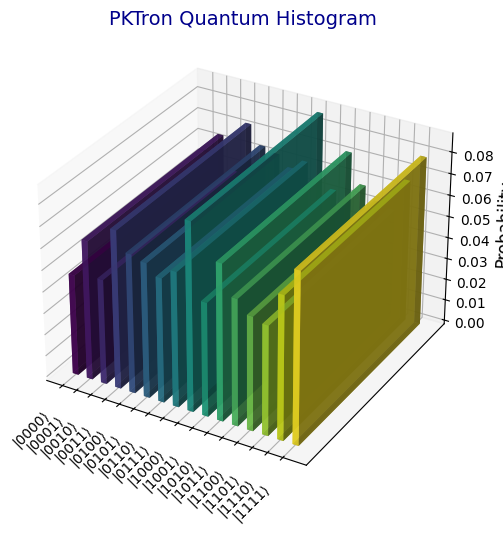

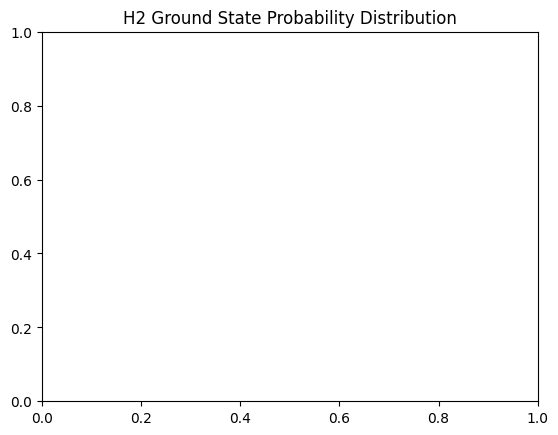

In [5]:
try:
    qc_vqe = vqe_result['circuit']
    plot_histogram(qc_vqe, shots=1024)
    plt.title("H2 Ground State Probability Distribution")
    plt.show()
except Exception as e:
    print(f"Histogram visualization failed: {e}")

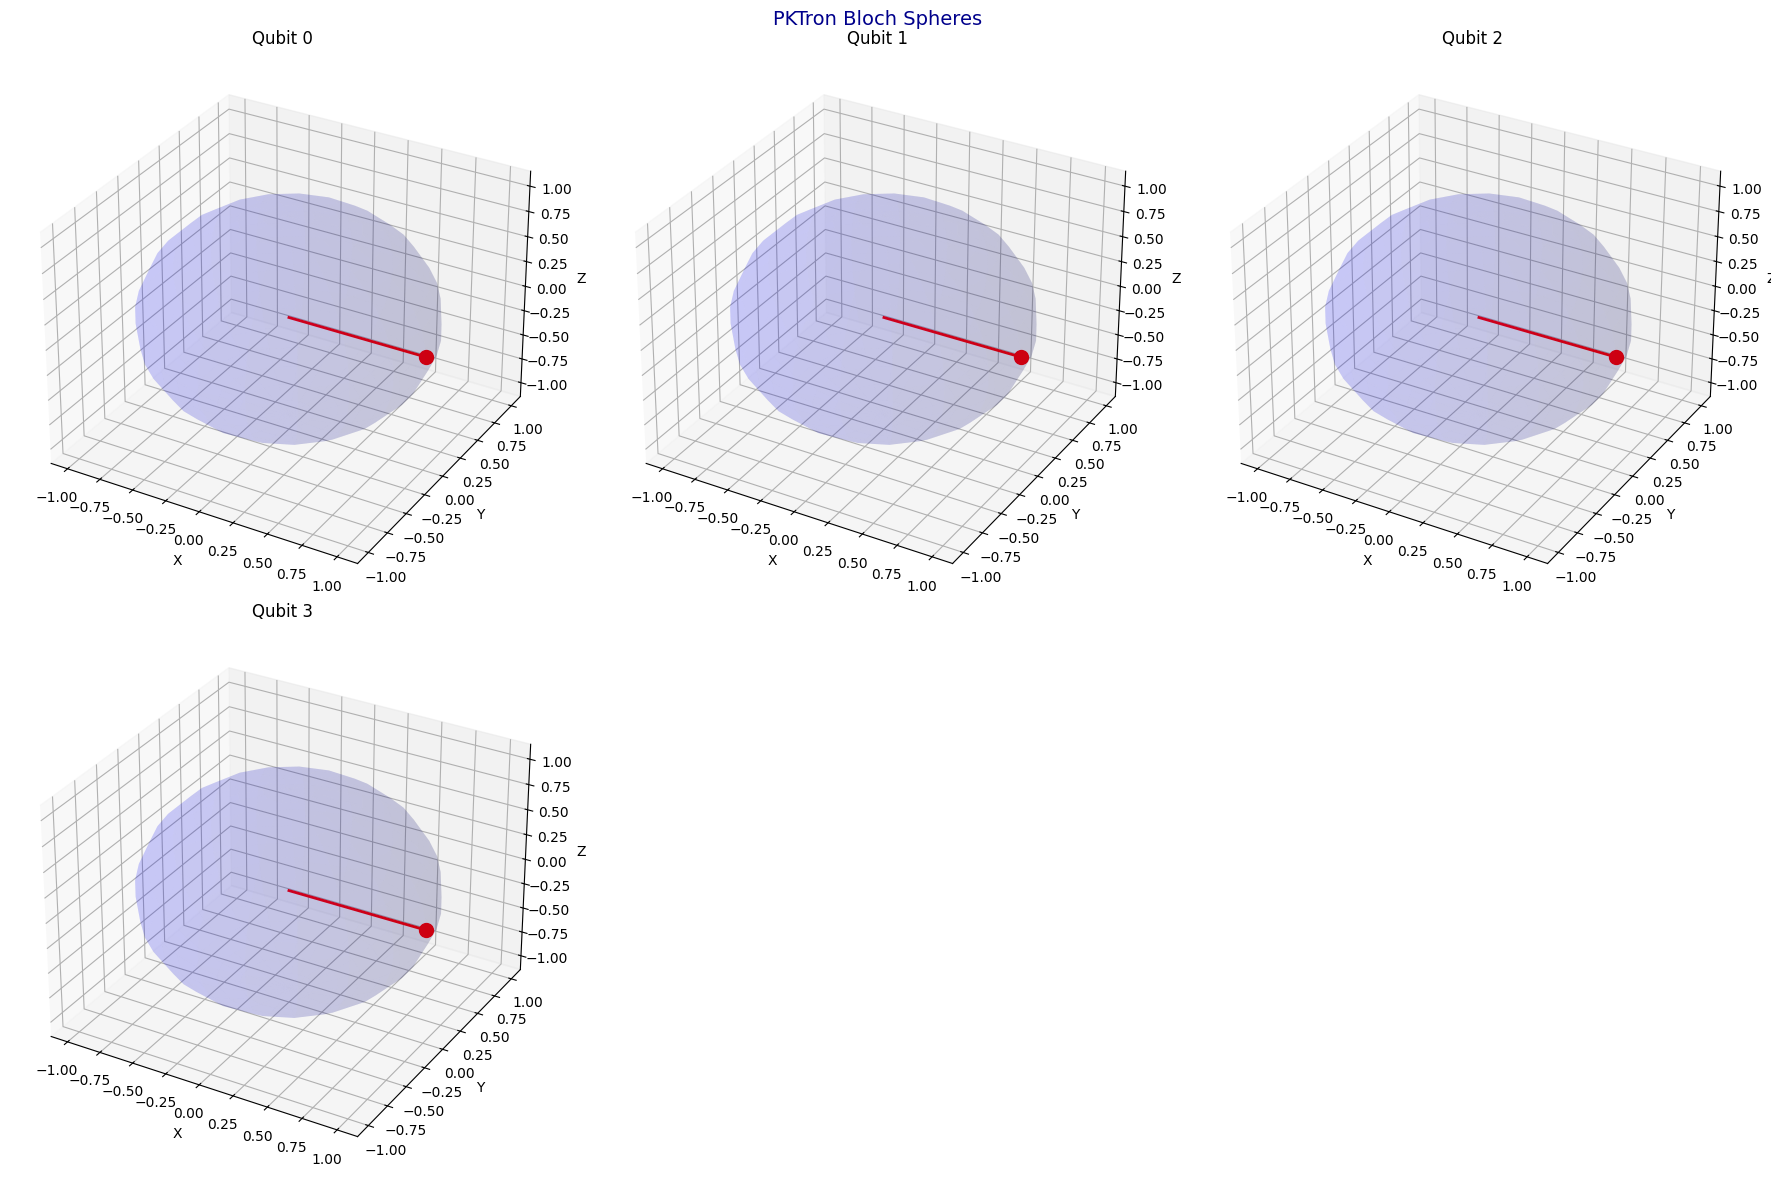

<Figure size 640x480 with 0 Axes>

In [8]:
try:
    plot_bloch(qc_vqe)
    plt.suptitle("Bloch Spheres for H2 VQE State")
    plt.show()
except Exception as e:
    print(f"Bloch visualization failed: {e}")